In [1]:
import os
import glob
import pandas as pd 
import geopandas as gpd
from geopandas import GeoDataFrame
import os
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
import seaborn as sns

from urllib.error import HTTPError
import urllib.request as request
try:
    from urllib import urlretrieve as urlretrieve
except ImportError:
    from urllib.request import urlretrieve as urlretrieve
    
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.statespace as smstate

from statsmodels.graphics.api import qqplot
 
pd.options.mode.chained_assignment = None
%matplotlib inline

##  Need the shapefile that manrique got, didnt find shpfile in drive. so i am redoing here 

In [2]:
masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/ML4C/Project".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /Users/amber/ML4C/Project


In [3]:
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('Master')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)

In [4]:
NYCzip=gpd.read_file('Data/14000.shp')

In [5]:
NYCzip.rename(columns={"GEO_ID": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(str).str[-11:]
NYCzip.GEOID = NYCzip.GEOID.astype(int)

In [7]:
cols = ['GEOID']
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape

(2166, 1)

In [8]:
NYzip_url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
NYzip = getGeoDataFrameFromShpFileZipUrl(NYzip_url)

In [11]:
NYzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYzip.GEOID = NYzip.GEOID.astype(int)
cols = ['GEOID','geometry']
NYCzipgdp = NYzip.loc[:,cols]


In [12]:
NYCzipgdp = NYCzipgdp.merge(NYCzip,on='GEOID')
NYCzipgdp.head()

,GEOID,geometry
0,36081113900,POLYGON ((-73.79190199967752 40.76893599959674...
1,36061025700,POLYGON ((-73.95068000038171 40.81084300040413...
2,36047000502,POLYGON ((-73.99136499969497 40.69701000031133...
3,36081015802,POLYGON ((-73.81497399975029 40.68669500037402...
4,36047116000,POLYGON ((-73.88618300014529 40.66752100019399...


In [13]:
Censuspd = pd.read_stata('Data/UDP_NYC_Variables.dta')
Censuspdgdp = gpd.GeoDataFrame(Censuspd)

In [14]:
for column in Censuspdgdp.columns:
    Censuspdgdp[column] = pd.to_numeric(Censuspdgdp[column].values, errors='coerce')

In [15]:
Censuspdgdp.rename(columns={'GEOid2': "GEOID"},inplace=True)
Censuspdgdp.tail(2)

,GEOID,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,...,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16
5336,36119984000,92.0,37.0,0.121495,0.517544,0.0,0.220431,0.394953,-1.490116e-08,0.019975,...,749.0,0.255689,48.0,38929.0,16474.0,-54.0,46444.95,55472.790653,-0.162744,-0.161825
5337,36119985000,0.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data_census = NYCzipgdp.merge(Censuspdgdp,on='GEOID')
data_census.tail()

,GEOID,geometry,hh16,moe_hh16,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,...,pop90,per_col90,moe_hu16,hinc16,moe_hinc16,popgrowth,hinc00,hinc90,pct_ch_hinc90_00,pct_ch_hinc00_16
2159,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,4.0,6.0,0.134557,0.989928,1.000000,0.481906,0.208198,0.064489,...,0.854182,0.000095,6.0,NaN,NaN,7.006433,34971.10032,26333.700869,0.327998,NaN
2160,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,2876.0,150.0,0.152688,0.983061,0.942688,0.513238,0.179940,0.076447,...,4258.000000,0.075093,74.0,48429.0,6061.0,2092.000000,32256.70000,16680.450280,0.933803,0.501363
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",2083.0,115.0,0.057858,0.976335,0.988011,0.621887,0.177527,0.049810,...,5085.000000,0.055690,81.0,21585.0,5374.0,-8.000000,25044.40000,25103.939512,-0.002372,-0.138131
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,1117.0,97.0,0.282637,0.974572,0.827789,0.439632,0.187200,0.079572,...,1408.000000,0.161512,69.0,41635.0,13171.0,288.000000,43768.25000,35593.500000,0.229670,-0.048740
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",1064.0,59.0,0.422212,0.660112,0.521779,0.129393,0.100985,0.064595,...,3171.000000,1.036555,49.0,85147.0,22920.0,89.000000,84499.12500,98343.495042,-0.140776,0.007667


## Start analysis here

In [20]:
data_census.shape

(2164, 90)

In [21]:
# Using regressor of 2016
cols_16 = []
for column in data_census.columns:
    if '16' in column:
        cols_16.append(column)
cols_16 
print(len(cols_16),cols_16 )

34 ['hh16', 'moe_hh16', 'pop16', 'moe_pop16', 'ch_all_li_count00_16', 'moveinincd16', 'co_med_indinc16', 'per_limove16', 'mrent16', 'moe_mrent16', 'mhval16', 'moe_mhval16', 'mhval00_16', 'mrent00_16', 'hu16', 'ohu16', 'moe_owner16', 'rhu16', 'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016', 'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16', 'all_li_count16', 'per_col_16', 'moe_hu16', 'hinc16', 'moe_hinc16', 'pct_ch_hinc00_16']


In [22]:
# Create a new dataframe with Geoid and geometry for variable from 2016
df_16 = data_census[['hh16', 'moe_hh16', 'pop16', 'moe_pop16', 'ch_all_li_count00_16', 'moveinincd16', 'co_med_indinc16', 'per_limove16', 'mrent16', 'moe_mrent16', 'mhval16', 'moe_mhval16', 'mhval00_16', 'mrent00_16', 'hu16', 'ohu16', 'moe_owner16', 'rhu16', 'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016', 'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16', 'all_li_count16', 'per_col_16', 'moe_hu16', 'hinc16', 'moe_hinc16', 'pct_ch_hinc00_16']]
df_16.head()

,hh16,moe_hh16,pop16,moe_pop16,ch_all_li_count00_16,moveinincd16,co_med_indinc16,per_limove16,mrent16,moe_mrent16,...,hmi2016,hi2016,vhi2016,per_all_li16,all_li_count16,per_col_16,moe_hu16,hinc16,moe_hinc16,pct_ch_hinc00_16
0,1369.0,76.0,3238.0,291.0,133.823456,245.700,59758.0,0.395823,1546.0,115.0,...,0.121232,0.116617,0.275688,0.421141,576.541809,0.332690,47.0,60655.0,8461.0,-0.217644
1,1803.0,102.0,4511.0,428.0,-126.051941,324.583,75513.0,0.555169,1624.0,236.0,...,0.072037,0.103051,0.352138,0.408829,737.118958,0.641879,47.0,76832.0,4932.0,1.463107
2,1528.0,92.0,2618.0,232.0,7.001373,458.835,50640.0,0.125220,1998.0,171.0,...,0.041985,0.057042,0.650256,0.203195,310.481598,0.866088,31.0,100805.0,8522.0,0.069335
3,1235.0,58.0,4862.0,405.0,-100.156677,337.804,59758.0,0.578571,1467.0,109.0,...,0.078507,0.122173,0.363464,0.367679,454.083557,0.188823,46.0,69453.0,15548.0,0.131579
4,896.0,48.0,2031.0,203.0,124.415955,56.529,50640.0,0.757346,780.0,153.0,...,0.071625,0.129686,0.152520,0.616670,552.536011,0.144699,21.0,28750.0,7007.0,-0.148336


#### data exploration

In [23]:
df_16.isnull().sum()

hh16                      0
moe_hh16                  0
pop16                     0
moe_pop16                 0
ch_all_li_count00_16     53
moveinincd16              0
co_med_indinc16           0
per_limove16             50
mrent16                   0
moe_mrent16              77
mhval16                   0
moe_mhval16             255
mhval00_16               76
mrent00_16               45
hu16                      0
ohu16                     0
moe_owner16               0
rhu16                     0
moe_renter16              0
per_rent16               44
per_nonwhite16           36
vli2016                  44
li2016                   44
mi2016                   44
hmi2016                  44
hi2016                   44
vhi2016                  44
per_all_li16             44
all_li_count16           44
per_col_16               36
moe_hu16                  0
hinc16                   61
moe_hinc16               62
pct_ch_hinc00_16         65
dtype: int64

In [24]:
# handle nan value 
df_16.isnull().sum()[df_16.isnull().sum()>0]

ch_all_li_count00_16     53
per_limove16             50
moe_mrent16              77
moe_mhval16             255
mhval00_16               76
mrent00_16               45
per_rent16               44
per_nonwhite16           36
vli2016                  44
li2016                   44
mi2016                   44
hmi2016                  44
hi2016                   44
vhi2016                  44
per_all_li16             44
all_li_count16           44
per_col_16               36
hinc16                   61
moe_hinc16               62
pct_ch_hinc00_16         65
dtype: int64

In [25]:
df_16= df_16.replace('nan',0)
df_16= df_16.replace(np.nan,0)
df_16= df_16.replace('NaN',0)
df_16.shape

(2164, 34)

In [26]:
# drop those variable that have more than 50 missing values 
df_16_new = df_16.drop(['ch_all_li_count00_16','moe_mrent16','moe_mhval16','mhval00_16','mrent00_16','hinc16','moe_hinc16','pct_ch_hinc00_16'], axis=1)
df_16_new.head()


,hh16,moe_hh16,pop16,moe_pop16,moveinincd16,co_med_indinc16,per_limove16,mrent16,mhval16,hu16,...,vli2016,li2016,mi2016,hmi2016,hi2016,vhi2016,per_all_li16,all_li_count16,per_col_16,moe_hu16
0,1369.0,76.0,3238.0,291.0,245.700,59758.0,0.395823,1546.0,557700.0,1448.0,...,0.230920,0.190221,0.065322,0.121232,0.116617,0.275688,0.421141,576.541809,0.332690,47.0
1,1803.0,102.0,4511.0,428.0,324.583,75513.0,0.555169,1624.0,827200.0,1984.0,...,0.217857,0.190972,0.063945,0.072037,0.103051,0.352138,0.408829,737.118958,0.641879,47.0
2,1528.0,92.0,2618.0,232.0,458.835,50640.0,0.125220,1998.0,490200.0,1672.0,...,0.143592,0.059603,0.047523,0.041985,0.057042,0.650256,0.203195,310.481598,0.866088,31.0
3,1235.0,58.0,4862.0,405.0,337.804,59758.0,0.578571,1467.0,408600.0,1284.0,...,0.182911,0.184768,0.068177,0.078507,0.122173,0.363464,0.367679,454.083557,0.188823,46.0
4,896.0,48.0,2031.0,203.0,56.529,50640.0,0.757346,780.0,342400.0,984.0,...,0.456009,0.160661,0.029500,0.071625,0.129686,0.152520,0.616670,552.536011,0.144699,21.0


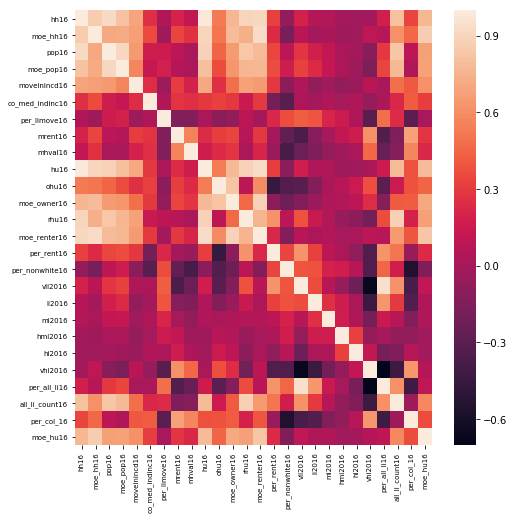

In [27]:
corr = df_16_new.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr)
plt.yticks(rotation=0, size=7)
plt.xticks(rotation=90, size=7)
plt.show()

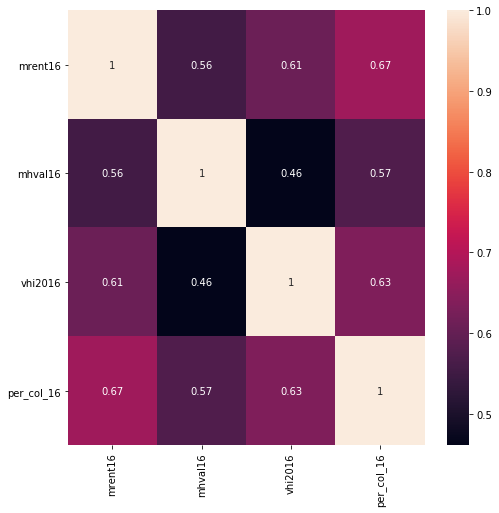

In [28]:
rel_vars = corr.mhval16 [(corr.mhval16  > 0.4)]
rel_cols = list(rel_vars.index.values)

corr2 = df_16_new[rel_cols].corr()
plt.figure(figsize=(8,8))
hm = sns.heatmap(corr2, annot=True, annot_kws={'size':10})
plt.yticks(rotation=0, size=10)
plt.xticks(rotation=90, size=10)
plt.show()

## After check the variable dictionary, the top three correlation variables are : per_col_16 --- "Percent college educated" /  mrent16 ---"Median house value" / vhi2016 --- "Share of very high income households". 

In [29]:
# Create a new dataframe with Geoid and geometry for variable from 2016
df_16_geo = data_census[['GEOID', 'geometry','hh16', 'moe_hh16', 'pop16', 'moe_pop16', 'ch_all_li_count00_16', 'moveinincd16', 'co_med_indinc16', 'per_limove16', 'mrent16', 'moe_mrent16', 'mhval16', 'moe_mhval16', 'mhval00_16', 'mrent00_16', 'hu16', 'ohu16', 'moe_owner16', 'rhu16', 'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016', 'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16', 'all_li_count16', 'per_col_16', 'moe_hu16', 'hinc16', 'moe_hinc16', 'pct_ch_hinc00_16']]
df_16_geo.head()

,GEOID,geometry,hh16,moe_hh16,pop16,moe_pop16,ch_all_li_count00_16,moveinincd16,co_med_indinc16,per_limove16,...,hmi2016,hi2016,vhi2016,per_all_li16,all_li_count16,per_col_16,moe_hu16,hinc16,moe_hinc16,pct_ch_hinc00_16
0,36081113900,POLYGON ((-73.79190199967752 40.76893599959674...,1369.0,76.0,3238.0,291.0,133.823456,245.700,59758.0,0.395823,...,0.121232,0.116617,0.275688,0.421141,576.541809,0.332690,47.0,60655.0,8461.0,-0.217644
1,36061025700,POLYGON ((-73.95068000038171 40.81084300040413...,1803.0,102.0,4511.0,428.0,-126.051941,324.583,75513.0,0.555169,...,0.072037,0.103051,0.352138,0.408829,737.118958,0.641879,47.0,76832.0,4932.0,1.463107
2,36047000502,POLYGON ((-73.99136499969497 40.69701000031133...,1528.0,92.0,2618.0,232.0,7.001373,458.835,50640.0,0.125220,...,0.041985,0.057042,0.650256,0.203195,310.481598,0.866088,31.0,100805.0,8522.0,0.069335
3,36081015802,POLYGON ((-73.81497399975029 40.68669500037402...,1235.0,58.0,4862.0,405.0,-100.156677,337.804,59758.0,0.578571,...,0.078507,0.122173,0.363464,0.367679,454.083557,0.188823,46.0,69453.0,15548.0,0.131579
4,36047116000,POLYGON ((-73.88618300014529 40.66752100019399...,896.0,48.0,2031.0,203.0,124.415955,56.529,50640.0,0.757346,...,0.071625,0.129686,0.152520,0.616670,552.536011,0.144699,21.0,28750.0,7007.0,-0.148336


In [30]:
df_16_geo= df_16_geo.replace('nan',0)
df_16_geo= df_16_geo.replace(np.nan,0)
df_16_geo= df_16_geo.replace('NaN',0)

## Then check the clustering only for 2016 

In [31]:
# With 2016 data

print(df_16_geo.shape)

cols_X = [i for i in df_16_geo.columns if (i != 'mhval16')&(i != 'GEOID')&(i !='geometry')]
print(cols_X)

(2164, 36)
['hh16', 'moe_hh16', 'pop16', 'moe_pop16', 'ch_all_li_count00_16', 'moveinincd16', 'co_med_indinc16', 'per_limove16', 'mrent16', 'moe_mrent16', 'moe_mhval16', 'mhval00_16', 'mrent00_16', 'hu16', 'ohu16', 'moe_owner16', 'rhu16', 'moe_renter16', 'per_rent16', 'per_nonwhite16', 'vli2016', 'li2016', 'mi2016', 'hmi2016', 'hi2016', 'vhi2016', 'per_all_li16', 'all_li_count16', 'per_col_16', 'moe_hu16', 'hinc16', 'moe_hinc16', 'pct_ch_hinc00_16']


In [32]:
X = np.asarray(df_16_geo[cols_X])
print(X.shape)
y = np.asarray(df_16_geo['mhval16'])
y

(2164, 33)


array([ 557700.,  827200.,  490200., ...,       0.,  537900., 1146400.])

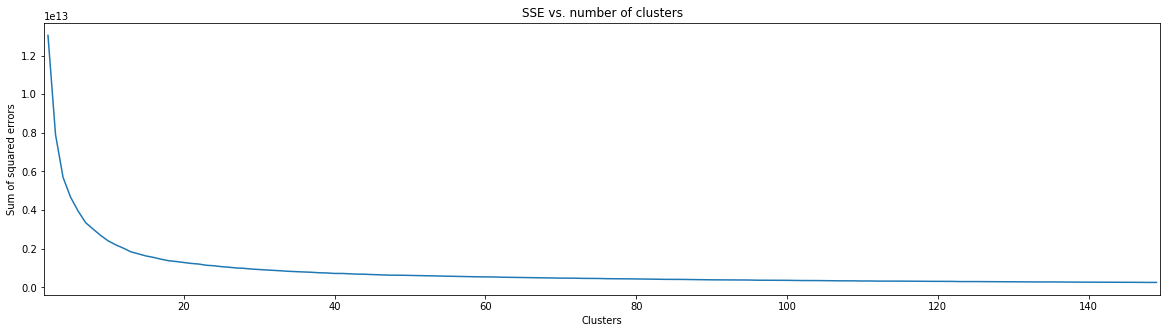

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

SSE = []
for i in range(2,150):
    km = KMeans(n_clusters = i)
    res=km.fit(X)
    SSE.append(res.inertia_)
# print(SSE)

plt.figure(figsize=(20,5))
plt.gca()
plt.plot(range(2,150),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,149.5)
plt.show()

In [38]:


range_n_clusters = range(2,20)

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters)
    res=km.fit(X)
    silhouette_avg = silhouette_score(X, res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))
    
        

For n_clusters = 2, the average silhouette_score is : 0.7029014192702603
For n_clusters = 3, the average silhouette_score is : 0.5869307469791986
For n_clusters = 4, the average silhouette_score is : 0.4598503718454821
For n_clusters = 5, the average silhouette_score is : 0.4369946921574069
For n_clusters = 6, the average silhouette_score is : 0.3348609479071667
For n_clusters = 7, the average silhouette_score is : 0.3350718803762613
For n_clusters = 8, the average silhouette_score is : 0.33059803716880604
For n_clusters = 9, the average silhouette_score is : 0.30779532030634704
For n_clusters = 10, the average silhouette_score is : 0.31776673307251607
For n_clusters = 11, the average silhouette_score is : 0.3047245917972967
For n_clusters = 12, the average silhouette_score is : 0.3101731528003815
For n_clusters = 13, the average silhouette_score is : 0.32263797834738883
For n_clusters = 14, the average silhouette_score is : 0.3314694518651236
For n_clusters = 15, the average silhouett

In [39]:
y_clusters = res.labels_
y_clusters

array([ 4, 13, 13, ...,  8,  4, 13], dtype=int32)

In [40]:
df_16_geo['clusters'] =y_clusters
df_16_geo['clusters'].unique()
df_16_geo.to_csv('clusters_16.csv')
df_16_geo.tail(3)

,GEOID,geometry,hh16,moe_hh16,pop16,moe_pop16,ch_all_li_count00_16,moveinincd16,co_med_indinc16,per_limove16,...,hi2016,vhi2016,per_all_li16,all_li_count16,per_col_16,moe_hu16,hinc16,moe_hinc16,pct_ch_hinc00_16,clusters
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",2083.0,115.0,6415.0,755.0,-57.557861,506.445,75513.0,0.719861,...,0.032178,0.065179,0.836641,1742.723755,0.186234,81.0,21585.0,5374.0,-0.138131,8
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,1117.0,97.0,2451.0,291.0,22.305359,245.920,75513.0,0.788569,...,0.066406,0.204434,0.593489,662.927551,0.519689,69.0,41635.0,13171.0,-0.048740,4
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",1064.0,59.0,3496.0,370.0,30.123215,173.047,50640.0,0.607703,...,0.120580,0.548916,0.266917,284.000000,0.561866,49.0,85147.0,22920.0,0.007667,13


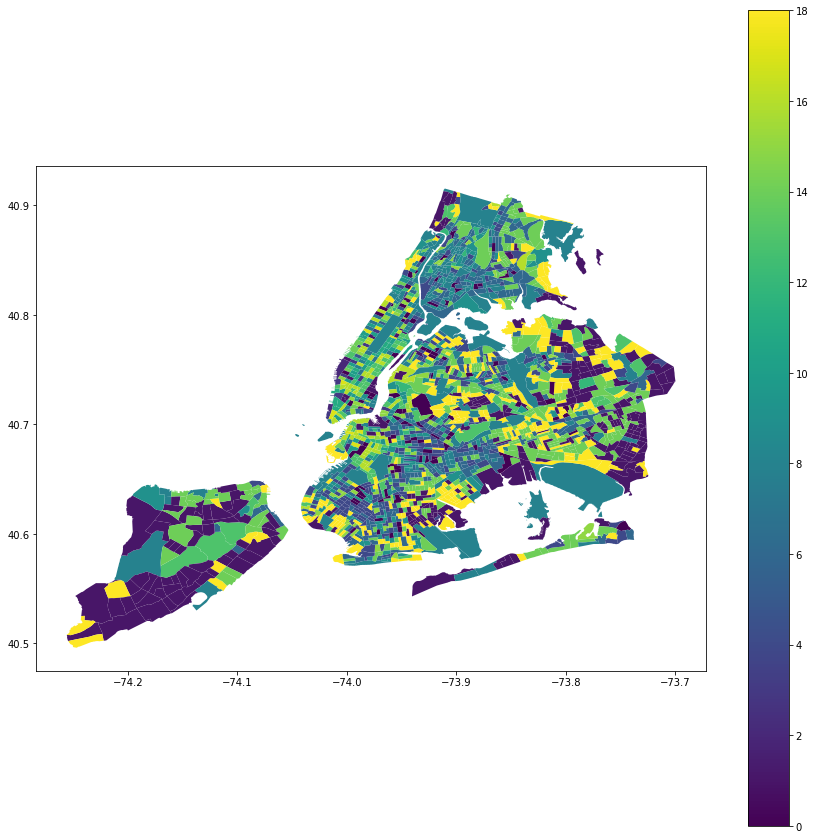

In [42]:
figure, ax = plt.subplots(figsize=(15, 15))
df_16_geo.plot(column='clusters',legend = True, ax=ax)

## Redo for 2010 and 1990 ---> check if the cluster was changed 

In [43]:
cols_00 = []
for column in data_census.columns:
    if '00' in column:
        cols_00.append(column)
cols_16 
print(len(cols_00),cols_00)

26 ['per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'pop00', 'ch_all_li_count90_00', 'ch_all_li_count00_16', 'mrent00', 'rou00', 'mhval00', 'ohu00', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hinc00', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16']


In [44]:
#create matrix with independent variable 

In [45]:
df_00 = data_census[['per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'pop00', 'ch_all_li_count90_00', 'ch_all_li_count00_16', 'mrent00', 'rou00', 'mhval00', 'ohu00', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hinc00', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16']]
df_00.head()

,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,hi2000,vhi2000,per_all_li00,...,rou00,mhval00,ohu00,mhval90_00,mhval00_16,mrent90_00,mrent00_16,hinc00,pct_ch_hinc90_00,pct_ch_hinc00_16
0,0.308353,0.392846,0.588881,0.165321,0.138535,0.059451,0.100951,0.138998,0.396744,0.303856,...,858.000000,230500.000000,599.000000,-0.010305,1.419523,0.371069,0.772936,77528.600000,0.024456,-0.217644
1,0.165272,0.955867,0.883148,0.487993,0.198152,0.073064,0.044690,0.072732,0.123368,0.686145,...,1111.000000,133982.312925,147.000000,-0.021966,5.173949,0.638764,2.009309,31193.126153,0.338241,1.463107
2,0.779420,0.170020,0.618152,0.119530,0.063569,0.035175,0.065627,0.095087,0.621012,0.183099,...,1024.565796,217699.995305,632.898621,-0.564601,1.251723,0.643761,1.198020,94268.847010,0.237521,0.069335
3,0.091283,0.955941,0.451968,0.248304,0.170377,0.082061,0.139400,0.113894,0.245964,0.418681,...,598.304321,192400.007635,725.471985,0.269967,1.123700,0.085799,0.998638,61377.049024,-0.045143,0.131579
4,0.124260,0.993137,0.651192,0.389734,0.147430,0.087068,0.033895,0.064730,0.277142,0.537164,...,519.000000,151700.000000,278.000000,0.348444,1.257086,-0.027027,0.805556,33757.450000,-0.019158,-0.148336


In [46]:
df_00= df_00.replace('nan',0)
df_00= df_00.replace(np.nan,0)
df_00= df_00.replace('NaN',0)
df_00.shape

(2164, 26)

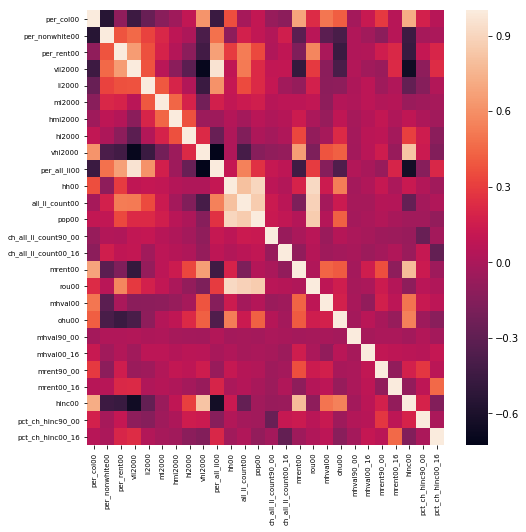

In [47]:
corr = df_00.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr)
plt.yticks(rotation=0, size=7)
plt.xticks(rotation=90, size=7)
plt.show()

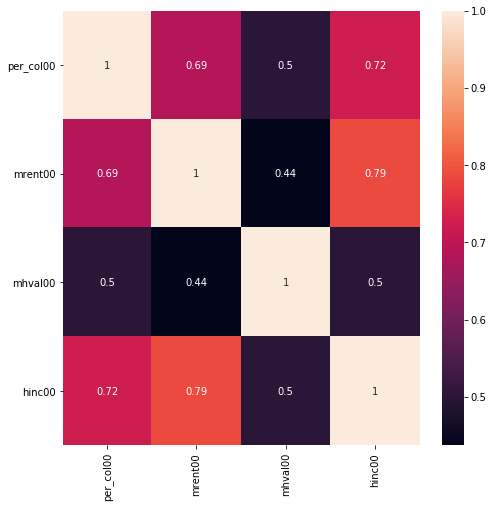

In [48]:
rel_vars = corr.mhval00 [(corr.mhval00  > 0.4)]
rel_cols = list(rel_vars.index.values)

corr2 = df_00[rel_cols].corr()
plt.figure(figsize=(8,8))
hm = sns.heatmap(corr2, annot=True, annot_kws={'size':10})
plt.yticks(rotation=0, size=10)
plt.xticks(rotation=90, size=10)
plt.show()

## Same as 2016,  in 2000, the top three correlation variables are : per_col_16 --- "Percent college educated" /  mrent16 ---"Median house value" / vhi2016 --- "Share of very high income households".  (the college one is intresting, but the income one is kinda obvious i feel) 

In [ ]:
# perform clustering on 2000

In [50]:
# Create a new dataframe with Geoid and geometry for variable from 2000
df_00_geo = data_census[['GEOID', 'geometry', 'per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'pop00', 'ch_all_li_count90_00', 'ch_all_li_count00_16', 'mrent00', 'rou00', 'mhval00', 'ohu00', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hinc00', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16']]
df_00_geo.head()

,GEOID,geometry,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,hi2000,...,rou00,mhval00,ohu00,mhval90_00,mhval00_16,mrent90_00,mrent00_16,hinc00,pct_ch_hinc90_00,pct_ch_hinc00_16
0,36081113900,POLYGON ((-73.79190199967752 40.76893599959674...,0.308353,0.392846,0.588881,0.165321,0.138535,0.059451,0.100951,0.138998,...,858.000000,230500.000000,599.000000,-0.010305,1.419523,0.371069,0.772936,77528.600000,0.024456,-0.217644
1,36061025700,POLYGON ((-73.95068000038171 40.81084300040413...,0.165272,0.955867,0.883148,0.487993,0.198152,0.073064,0.044690,0.072732,...,1111.000000,133982.312925,147.000000,-0.021966,5.173949,0.638764,2.009309,31193.126153,0.338241,1.463107
2,36047000502,POLYGON ((-73.99136499969497 40.69701000031133...,0.779420,0.170020,0.618152,0.119530,0.063569,0.035175,0.065627,0.095087,...,1024.565796,217699.995305,632.898621,-0.564601,1.251723,0.643761,1.198020,94268.847010,0.237521,0.069335
3,36081015802,POLYGON ((-73.81497399975029 40.68669500037402...,0.091283,0.955941,0.451968,0.248304,0.170377,0.082061,0.139400,0.113894,...,598.304321,192400.007635,725.471985,0.269967,1.123700,0.085799,0.998638,61377.049024,-0.045143,0.131579
4,36047116000,POLYGON ((-73.88618300014529 40.66752100019399...,0.124260,0.993137,0.651192,0.389734,0.147430,0.087068,0.033895,0.064730,...,519.000000,151700.000000,278.000000,0.348444,1.257086,-0.027027,0.805556,33757.450000,-0.019158,-0.148336


In [51]:
df_00_geo= df_00_geo.replace('nan',0)
df_00_geo= df_00_geo.replace(np.nan,0)
df_00_geo= df_00_geo.replace('NaN',0)

In [53]:
# With 2000 data

print(df_00_geo.shape)

cols_X = [i for i in df_00_geo.columns if (i != 'mhval00')&(i != 'GEOID')&(i !='geometry')]
print(cols_X)

(2164, 28)
['per_col00', 'per_nonwhite00', 'per_rent00', 'vli2000', 'li2000', 'mi2000', 'hmi2000', 'hi2000', 'vhi2000', 'per_all_li00', 'hh00', 'all_li_count00', 'pop00', 'ch_all_li_count90_00', 'ch_all_li_count00_16', 'mrent00', 'rou00', 'ohu00', 'mhval90_00', 'mhval00_16', 'mrent90_00', 'mrent00_16', 'hinc00', 'pct_ch_hinc90_00', 'pct_ch_hinc00_16']


In [54]:
X = np.asarray(df_00_geo[cols_X])
print(X.shape)
y = np.asarray(df_00_geo['mhval00'])
y

(2164, 25)


array([230500.        , 133982.31292517, 217699.99530495, ...,
       625000.        , 175000.        , 361840.60721063])

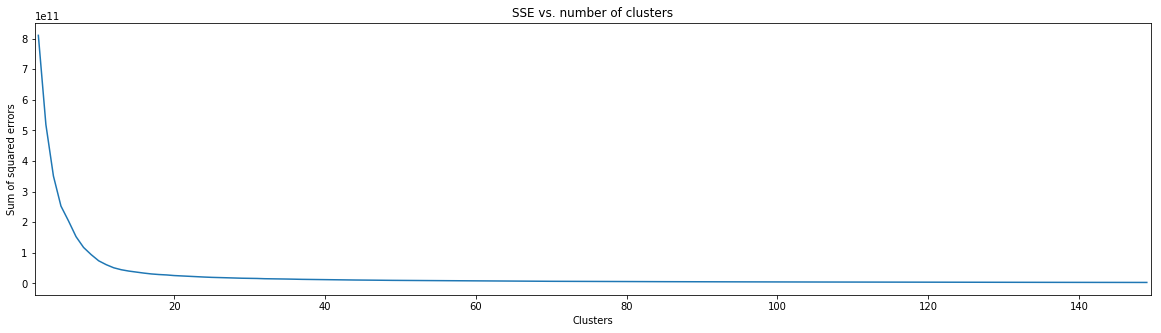

In [55]:

SSE = []
for i in range(2,150):
    km = KMeans(n_clusters = i)
    res=km.fit(X)
    SSE.append(res.inertia_)
# print(SSE)

plt.figure(figsize=(20,5))
plt.gca()
plt.plot(range(2,150),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,149.5)
plt.show()

In [56]:
range_n_clusters = range(2,20)

for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters)
    res=km.fit(X)
    silhouette_avg = silhouette_score(X, res.labels_)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))
    

For n_clusters = 2, the average silhouette_score is : 0.5518688721634138
For n_clusters = 3, the average silhouette_score is : 0.4976672614017573
For n_clusters = 4, the average silhouette_score is : 0.5007477155987214
For n_clusters = 5, the average silhouette_score is : 0.49887052457557085
For n_clusters = 6, the average silhouette_score is : 0.5030153475743657
For n_clusters = 7, the average silhouette_score is : 0.49849750386220537
For n_clusters = 8, the average silhouette_score is : 0.4746106968359963
For n_clusters = 9, the average silhouette_score is : 0.47369957666556833
For n_clusters = 10, the average silhouette_score is : 0.48439556384370125
For n_clusters = 11, the average silhouette_score is : 0.4694330397744607
For n_clusters = 12, the average silhouette_score is : 0.46656222370591
For n_clusters = 13, the average silhouette_score is : 0.45126046174889245
For n_clusters = 14, the average silhouette_score is : 0.4439486078944327
For n_clusters = 15, the average silhouette

In [57]:
y_clusters = res.labels_
y_clusters

array([ 4,  2,  8, ..., 17,  9, 13], dtype=int32)

In [58]:
df_00_geo['clusters'] =y_clusters
df_00_geo['clusters'].unique()
df_00_geo.to_csv('clusters_00.csv')
df_00_geo.tail(3)

,GEOID,geometry,per_col00,per_nonwhite00,per_rent00,vli2000,li2000,mi2000,hmi2000,hi2000,...,mhval00,ohu00,mhval90_00,mhval00_16,mrent90_00,mrent00_16,hinc00,pct_ch_hinc90_00,pct_ch_hinc00_16,clusters
2161,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",0.057858,0.976335,0.988011,0.621887,0.177527,0.049810,0.044513,0.040544,...,625000.000000,27.0,0.000000,-1.000000,0.372990,0.236534,25044.400,-0.002372,-0.138131,17
2162,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,0.282637,0.974572,0.827789,0.439632,0.187200,0.079572,0.056022,0.087187,...,175000.000000,176.0,-0.066667,2.073714,0.768997,1.054983,43768.250,0.229670,-0.048740,9
2163,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",0.422212,0.660112,0.521779,0.129393,0.100985,0.064595,0.053479,0.082005,...,361840.607211,527.0,0.205564,2.168246,0.398152,0.976885,84499.125,-0.140776,0.007667,13


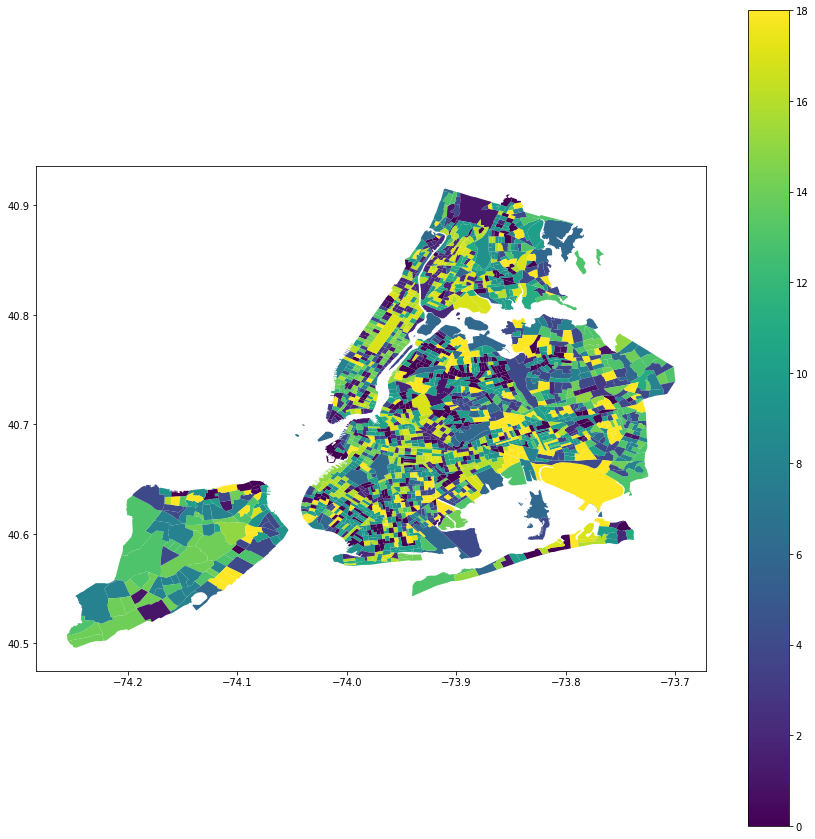

In [59]:
figure, ax = plt.subplots(figsize=(15, 15))
df_00_geo.plot(column='clusters',legend = True, ax=ax)

In [ ]:
## Little explore on random forest prediction on 2016 data 

In [65]:
X = df_16_new[rel_cols[:-1]].iloc[:,0:].values
y = df_16_new.iloc[:, -1].values

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0)

In [67]:
# Fit Random Forest on Training Set
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=300, random_state=0)
regressor.fit(X_train, y_train)

# Score model
regressor.score(X_train, y_train)

0.8807143230388311

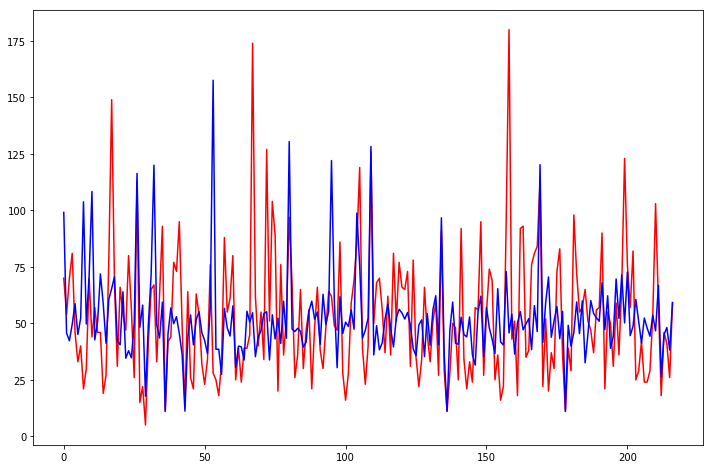

In [69]:
# Predict new result
y_pred = regressor.predict(X_test)
# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(y_test, color='red')
plt.plot(y_pred, color='blue')
plt.show()